## LSTM_ThirdDayPrediction

In this notebook, our goal is to conduct a comprehensive analysis of meteorological data for Traverse City. To achieve meaningful insights and build predictive models, we will follow a systematic approach to preprocess the data and engineer relevant features. Our primary focus will be on predicting precipitation based on various meteorological variables.

In [1]:
# Import necessary libraries for data handling, visualization, and modeling

import numpy as np
import pandas as pd
import math

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, KFold

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix, \
accuracy_score, classification_report, f1_score

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

## Time-Series Analysis and Precipitation Prediction

We aim to predict precipitation using a time-series approach. Here is our approach:

### Data Preprocessing:

- **Date and Time Handling:** Combine 'Date' and 'Time' columns into a DateTime object.
- **Label Quantization:** Create a new 'precip_class' label by quantizing precipitation into binary categories.

### Feature Engineering:

- **Identify Daily Patterns:** Analyze daily variability and identify patterns within the observed time range (9 am to 6 pm).
- **Experiment with Window Sizes:** Based on insights, experiment with different window sizes for creating sequences.

### Lagged Features for Time Series Modeling:

- To capture temporal dependencies and facilitate time series modeling, we will introduce lagged features. Specifically, we will create lagged versions of the meteorological variables to represent historical values. This step is crucial for training models that can effectively leverage the temporal nature of meteorological data.

### Model Building:

- **LSTM Model:** Train an LSTM model to capture temporal dependencies.
- **Feature Scaling:** Standardize features to ensure the model's stability.

### Evaluation:

- **Model Training:** Train the LSTM RNN model on the training dataset.
- **Validation:** Evaluate the model's performance using different window sizes on a validation set.

### Loading the dataset

In [3]:
df = pd.read_csv(r"./Data/2006Fall_2017Spring_GOES_meteo_combined.csv")
df

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F)
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,44,7,150,m,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,44,8,150,m,6000,m,m,10,983.7,1006.50,1006.40,0.00,44,NC
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,44,6,M,m,5500,11000,m,10,982.7,1005.70,1005.40,0.00,45,NC
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,44,8,150,m,6000,m,m,10,982.0,1005.10,1004.70,0.00,44,NC
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,45,5,M,m,2200,3500,m,8,982.0,1004.90,1004.70,0.02,46,NC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,2015-03-31,19:00,2015-03-31,19:00,goes15.2015.03.31.1900.v01.nc-var1-t0.csv,T_goes15.2015.03.31.1900.v01.nc-var1-t0.csv.csv,"[0.22, 0.1925, 0.1775, 0.16749999, 0.16499999,...","[array([ nan, nan, nan, ...",37.0,66.0,27.0,11,310,18,3500,5500,m,10,990.70,1014.10,1013.50,0.00,29,NC
48117,2015-03-31,20:00,2015-03-31,20:00,goes15.2015.03.31.2000.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2000.v01.nc-var1-t0.csv.csv,"[0.2575, 0.22, 0.21249999, 0.17999999, 0.185, ...","[array([ nan, nan, nan, nan, nan...",36.0,85.0,32.0,0,0,m,2100,2900,5000,10,991.00,1014.60,1013.90,0.00,NC,NC
48118,2015-03-31,21:00,2015-03-31,21:00,goes15.2015.03.31.2100.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2100.v01.nc-var1-t0.csv.csv,"[0.2225, 0.18249999, 0.19, 0.17999999, 0.1725,...","[array([ nan, nan, nan, nan, nan, nan, n...",36.0,85.0,32.0,0,0,m,4600,m,m,10,991.70,1015.00,1014.60,0.00,NC,NC
48119,2015-03-31,22:00,2015-03-31,22:00,goes15.2015.03.31.2200.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2200.v01.nc-var1-t0.csv.csv,"[0.17999999, 0.16749999, 0.16749999, 0.16, 0.1...","[array([ nan, nan, nan, nan, nan...",36.0,81.0,31.0,0,0,m,4800,5500,m,10,991.70,1014.90,1014.60,0.00,NC,NC


Following is the description and features in our dataset:

>This dataset appears to contain weather-related information. It includes various weather-related measurements and conditions observed over time. Here's a brief description of each column:
> 
> 
> **Attribute Information**:
> 
> 1. *Date:* Date of the observation.
> 2. *Time:* Time of the observation.
> 3. *Temp (F):* Temperature in degrees Fahrenheit.
> 4. *RH (%):* Relative humidity in percentage.
> 5. *Dewpt (F):* Dew point temperature in degrees Fahrenheit.
> 6. *Wind Spd (mph):* Wind speed in miles per hour.
> 7. *Wind Direction (deg):* Wind direction in degrees.
> 9. *Peak Wind Gust(mph):* Peak wind gust speed in miles per hour.
> 10. *Low Cloud Ht (ft):* Height of low-level clouds in feet.
> 11. *Med Cloud Ht (ft):* Height of medium-level clouds in feet.
> 12. *High Cloud Ht (ft):* Height of high-level clouds in feet.
> 13. *Visibility (mi):* Visibility in miles.
> 14. *Atm Press (hPa):* Atmospheric pressure in hectopascals.
> 15. *Sea Lev Press (hPa):* Sea level pressure in hectopascals.
> 16. *Altimeter (hPa):* Altimeter setting in hectopascals.
> 17. *Precip (in):* Precipitation amount in inches.
> 18. *Wind Chill (F):* Wind chill temperature in degrees Fahrenheit.
> 19. *Heat Index (F):* Heat index temperature in degrees Fahrenheit.

In [4]:
# Identifying the data-type of each columnm in the dataset.

dtype = {}
for column in df.columns:
    dtype[column] = df[column].dtype
dtype

{'Date_UTC': dtype('O'),
 'Time_UTC': dtype('O'),
 'Date_CST': dtype('O'),
 'Time_CST': dtype('O'),
 'File_name_for_1D_lake': dtype('O'),
 'File_name_for_2D_lake': dtype('O'),
 'Lake_data_1D': dtype('O'),
 'Lake_data_2D': dtype('O'),
 'Temp (F)': dtype('O'),
 'RH (%)': dtype('O'),
 'Dewpt (F)': dtype('O'),
 'Wind Spd (mph)': dtype('O'),
 'Wind Direction (deg)': dtype('O'),
 'Peak Wind Gust(mph)': dtype('O'),
 'Low Cloud Ht (ft)': dtype('O'),
 'Med Cloud Ht (ft)': dtype('O'),
 'High Cloud Ht (ft)': dtype('O'),
 'Visibility (mi)': dtype('O'),
 'Atm Press (hPa)': dtype('O'),
 'Sea Lev Press (hPa)': dtype('O'),
 'Altimeter (hPa)': dtype('O'),
 'Precip (in)': dtype('O'),
 'Wind Chill (F)': dtype('O'),
 'Heat Index (F)': dtype('O')}

In [5]:
df = df.replace(['m','M'], '0')

In [6]:
df['Precip (in)'] = df['Precip (in)'].astype(float)

In [7]:
Dates = df['Date_UTC'].unique()

In [8]:
for i in Dates:
    # Calculate the sum of column 'C' where column 'B' is equal to 'X'
    df.loc[df['Date_UTC'] == i, 'tot_percip'] = df.loc[df['Date_UTC'] == i, 'Precip (in)'].sum()

In [9]:
df['DateTime'] = pd.to_datetime(df['Date_UTC'] + ' ' + df['Time_UTC'])
df

,Date_UTC,Time_UTC,Date_CST,Time_CST,File_name_for_1D_lake,File_name_for_2D_lake,Lake_data_1D,Lake_data_2D,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F),tot_percip,DateTime
0,2006-10-01,00:00,2006-09-30,00:00,goes11.2006.10.01.0000.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0000.v01.nc-var1-t0.csv.csv,"[0.0075, 0.0025, 0.0, 0.005, 0.0, 0.005, nan, ...","[array([ nan, nan, nan, nan, nan...",48,86,44,7,150,0,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC,0.03,2006-10-01 00:00:00
1,2006-10-01,01:00,2006-09-30,01:00,goes11.2006.10.01.0100.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0100.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0025, nan, 0.0, nan, 0...","[array([ nan, nan, nan, nan, nan...",48,86,44,8,150,0,6000,0,0,10,983.7,1006.50,1006.40,0.00,44,NC,0.03,2006-10-01 01:00:00
2,2006-10-01,02:00,2006-09-30,02:00,goes11.2006.10.01.0200.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0200.v01.nc-var1-t0.csv.csv,"[0.0, nan, 0.0075, nan, nan, 0.0025, nan, nan,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,44,6,0,0,5500,11000,0,10,982.7,1005.70,1005.40,0.00,45,NC,0.03,2006-10-01 02:00:00
3,2006-10-01,03:00,2006-09-30,03:00,goes11.2006.10.01.0300.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0300.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0025, 0.0, 0.0075, nan, 0.005,...","[array([nan, nan, nan, nan, nan, nan, nan, nan...",48,86,44,8,150,0,6000,0,0,10,982.0,1005.10,1004.70,0.00,44,NC,0.03,2006-10-01 03:00:00
4,2006-10-01,04:00,2006-09-30,04:00,goes11.2006.10.01.0400.v01.nc-var1-t0.csv,T_goes11.2006.10.01.0400.v01.nc-var1-t0.csv.csv,"[0.0025, nan, 0.0, nan, 0.0075, 0.0, nan, nan,...","[array([ nan, nan, nan, nan, nan...",48,89,45,5,0,0,2200,3500,0,8,982.0,1004.90,1004.70,0.02,46,NC,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,2015-03-31,19:00,2015-03-31,19:00,goes15.2015.03.31.1900.v01.nc-var1-t0.csv,T_goes15.2015.03.31.1900.v01.nc-var1-t0.csv.csv,"[0.22, 0.1925, 0.1775, 0.16749999, 0.16499999,...","[array([ nan, nan, nan, ...",37.0,66.0,27.0,11,310,18,3500,5500,0,10,990.70,1014.10,1013.50,0.00,29,NC,0.00,2015-03-31 19:00:00
48117,2015-03-31,20:00,2015-03-31,20:00,goes15.2015.03.31.2000.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2000.v01.nc-var1-t0.csv.csv,"[0.2575, 0.22, 0.21249999, 0.17999999, 0.185, ...","[array([ nan, nan, nan, nan, nan...",36.0,85.0,32.0,0,0,0,2100,2900,5000,10,991.00,1014.60,1013.90,0.00,NC,NC,0.00,2015-03-31 20:00:00
48118,2015-03-31,21:00,2015-03-31,21:00,goes15.2015.03.31.2100.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2100.v01.nc-var1-t0.csv.csv,"[0.2225, 0.18249999, 0.19, 0.17999999, 0.1725,...","[array([ nan, nan, nan, nan, nan, nan, n...",36.0,85.0,32.0,0,0,0,4600,0,0,10,991.70,1015.00,1014.60,0.00,NC,NC,0.00,2015-03-31 21:00:00
48119,2015-03-31,22:00,2015-03-31,22:00,goes15.2015.03.31.2200.v01.nc-var1-t0.csv,T_goes15.2015.03.31.2200.v01.nc-var1-t0.csv.csv,"[0.17999999, 0.16749999, 0.16749999, 0.16, 0.1...","[array([ nan, nan, nan, nan, nan...",36.0,81.0,31.0,0,0,0,4800,5500,0,10,991.70,1014.90,1014.60,0.00,NC,NC,0.00,2015-03-31 22:00:00


In [10]:
df.drop(['Date_UTC','Time_UTC','Date_CST','Time_CST','File_name_for_1D_lake','File_name_for_2D_lake','Lake_data_1D','Lake_data_2D'], axis=1, inplace=True)
df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),Wind Chill (F),Heat Index (F),tot_percip,DateTime
0,48,86,44,7,150,0,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,45,NC,0.03,2006-10-01 00:00:00
1,48,86,44,8,150,0,6000,0,0,10,983.7,1006.50,1006.40,0.00,44,NC,0.03,2006-10-01 01:00:00
2,48,86,44,6,0,0,5500,11000,0,10,982.7,1005.70,1005.40,0.00,45,NC,0.03,2006-10-01 02:00:00
3,48,86,44,8,150,0,6000,0,0,10,982.0,1005.10,1004.70,0.00,44,NC,0.03,2006-10-01 03:00:00
4,48,89,45,5,0,0,2200,3500,0,8,982.0,1004.90,1004.70,0.02,46,NC,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,37.0,66.0,27.0,11,310,18,3500,5500,0,10,990.70,1014.10,1013.50,0.00,29,NC,0.00,2015-03-31 19:00:00
48117,36.0,85.0,32.0,0,0,0,2100,2900,5000,10,991.00,1014.60,1013.90,0.00,NC,NC,0.00,2015-03-31 20:00:00
48118,36.0,85.0,32.0,0,0,0,4600,0,0,10,991.70,1015.00,1014.60,0.00,NC,NC,0.00,2015-03-31 21:00:00
48119,36.0,81.0,31.0,0,0,0,4800,5500,0,10,991.70,1014.90,1014.60,0.00,NC,NC,0.00,2015-03-31 22:00:00


In [11]:
# Identifying the data-type of each columnm in the dataset.

dtype = {}
for column in df.columns:
    dtype[column] = df[column].dtype
dtype

{'Temp (F)': dtype('O'),
 'RH (%)': dtype('O'),
 'Dewpt (F)': dtype('O'),
 'Wind Spd (mph)': dtype('O'),
 'Wind Direction (deg)': dtype('O'),
 'Peak Wind Gust(mph)': dtype('O'),
 'Low Cloud Ht (ft)': dtype('O'),
 'Med Cloud Ht (ft)': dtype('O'),
 'High Cloud Ht (ft)': dtype('O'),
 'Visibility (mi)': dtype('O'),
 'Atm Press (hPa)': dtype('O'),
 'Sea Lev Press (hPa)': dtype('O'),
 'Altimeter (hPa)': dtype('O'),
 'Precip (in)': dtype('float64'),
 'Wind Chill (F)': dtype('O'),
 'Heat Index (F)': dtype('O'),
 'tot_percip': dtype('float64'),
 'DateTime': dtype('<M8[ns]')}

We'll only filter data for day-time. This is done to avoid merging with night-time images later.

In [12]:
# Define the time range
# start_time = pd.to_datetime('14:00:00').time()
# end_time = pd.to_datetime('22:00:00').time()

# Filter the DataFrame based on the time range
# filtered_df = df[(df['DateTime'].dt.time >= start_time) & (df['DateTime'].dt.time <= end_time)]
# filtered_df

In [13]:
filtered_df =df

In [14]:
filtered_df['DateTime'].min()

Timestamp('2006-10-01 00:00:00')

In [15]:
filtered_df['DateTime'].max()

Timestamp('2017-03-31 23:00:00')

### Data cleaning and preprocessing

Let's observe some of the features which are marked as having 'Object' datatype.

In [16]:
filtered_df['Heat Index (F)'].value_counts()

Heat Index (F)
NC    47787
0        30
80       13
82       10
81       10
86        8
84        7
85        5
83        5
88        2
87        2
90        2
89        1
Name: count, dtype: int64

In [17]:
filtered_df['Wind Chill (F)'].value_counts()

Wind Chill (F)
NC     19685
21       969
27       916
19       914
22       884
       ...  
-28        4
-24        2
-30        2
-29        2
-27        1
Name: count, Length: 79, dtype: int64

In [18]:
# Dropping "Heat Index (F)" and "Wind Chill (F)" columns since majority datapoints don't carry any useful value.\
# NC: Wind Chill/Heat Index do not meet the required thresholds to be calculated.

filtered_df.drop(["Heat Index (F)","Wind Chill (F)"], axis=1, inplace=True)

In [19]:
filtered_df['Sea Lev Press (hPa)'].value_counts()

Sea Lev Press (hPa)
0          3207
1017.20     229
1017.30     227
1018.10     226
1018.00     225
           ... 
976.80        1
980.10        1
983.90        1
1038.40       1
1038.70       1
Name: count, Length: 612, dtype: int64

In [20]:
filtered_df['Wind Direction (deg)'].value_counts()

Wind Direction (deg)
0      13835
250     1677
240     1518
230     1515
260     1402
220     1393
210     1344
340     1342
350     1337
200     1266
270     1265
280     1237
290     1166
190     1072
300     1063
310     1040
360     1019
330      993
320      903
10       886
160      834
150      816
170      789
30       782
180      774
20       762
40       701
140      675
50       652
60       570
130      549
80       484
120      474
90       464
70       443
110      426
100      414
Name: count, dtype: int64

In [21]:
filtered_df['High Cloud Ht (ft)'].value_counts()

High Cloud Ht (ft)
0        42480
25000      443
6000       329
5000       296
5500       288
         ...  
4430         1
4630         1
4920         1
3640         1
6890         1
Name: count, Length: 74, dtype: int64

We observe that our dataset contains the value 'm' or 'M' for various datapoints across multiple features. This represents missing values and needs to be managed. To handle these missing values effectively, we can consider the following strategies:

* Imputation with a Specific Value
* Numeric Conversion
* Data Imputation Techniques to fill missing values with meaningful estimates like mean, median, mode imputation.
* Dropping Rows or Columns

We shall perform simple data preprocessing task by replacing all occurrences of 'm' or 'M' with '0' in the specified column of the DataFrame 'df'. This allows for consistent handling of missing data.

In [22]:
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
0,48,86,44,7,150,0,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,0.03,2006-10-01 00:00:00
1,48,86,44,8,150,0,6000,0,0,10,983.7,1006.50,1006.40,0.00,0.03,2006-10-01 01:00:00
2,48,86,44,6,0,0,5500,11000,0,10,982.7,1005.70,1005.40,0.00,0.03,2006-10-01 02:00:00
3,48,86,44,8,150,0,6000,0,0,10,982.0,1005.10,1004.70,0.00,0.03,2006-10-01 03:00:00
4,48,89,45,5,0,0,2200,3500,0,8,982.0,1004.90,1004.70,0.02,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,37.0,66.0,27.0,11,310,18,3500,5500,0,10,990.70,1014.10,1013.50,0.00,0.00,2015-03-31 19:00:00
48117,36.0,85.0,32.0,0,0,0,2100,2900,5000,10,991.00,1014.60,1013.90,0.00,0.00,2015-03-31 20:00:00
48118,36.0,85.0,32.0,0,0,0,4600,0,0,10,991.70,1015.00,1014.60,0.00,0.00,2015-03-31 21:00:00
48119,36.0,81.0,31.0,0,0,0,4800,5500,0,10,991.70,1014.90,1014.60,0.00,0.00,2015-03-31 22:00:00


In [23]:
filtered_df = filtered_df.replace(['m','M'], '0')
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
0,48,86,44,7,150,0,4100,4800,7000,10,984.0,1007.00,1006.80,0.00,0.03,2006-10-01 00:00:00
1,48,86,44,8,150,0,6000,0,0,10,983.7,1006.50,1006.40,0.00,0.03,2006-10-01 01:00:00
2,48,86,44,6,0,0,5500,11000,0,10,982.7,1005.70,1005.40,0.00,0.03,2006-10-01 02:00:00
3,48,86,44,8,150,0,6000,0,0,10,982.0,1005.10,1004.70,0.00,0.03,2006-10-01 03:00:00
4,48,89,45,5,0,0,2200,3500,0,8,982.0,1004.90,1004.70,0.02,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,37.0,66.0,27.0,11,310,18,3500,5500,0,10,990.70,1014.10,1013.50,0.00,0.00,2015-03-31 19:00:00
48117,36.0,85.0,32.0,0,0,0,2100,2900,5000,10,991.00,1014.60,1013.90,0.00,0.00,2015-03-31 20:00:00
48118,36.0,85.0,32.0,0,0,0,4600,0,0,10,991.70,1015.00,1014.60,0.00,0.00,2015-03-31 21:00:00
48119,36.0,81.0,31.0,0,0,0,4800,5500,0,10,991.70,1014.90,1014.60,0.00,0.00,2015-03-31 22:00:00


In [24]:
#Converting the columns to floating point data type

columns_to_update = ['Temp (F)','RH (%)','Dewpt (F)','Wind Spd (mph)','Wind Direction (deg)','Peak Wind Gust(mph)','Low Cloud Ht (ft)','Med Cloud Ht (ft)','High Cloud Ht (ft)','Visibility (mi)', 'Atm Press (hPa)', 'Sea Lev Press (hPa)', 'Altimeter (hPa)', 'Precip (in)']
for column in columns_to_update:
    filtered_df[column] = filtered_df[column].astype(float)
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00,0.03,2006-10-01 00:00:00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00,0.03,2006-10-01 01:00:00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00,0.03,2006-10-01 02:00:00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00,0.03,2006-10-01 03:00:00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,37.0,66.0,27.0,11.0,310.0,18.0,3500.0,5500.0,0.0,10.0,990.7,1014.1,1013.5,0.00,0.00,2015-03-31 19:00:00
48117,36.0,85.0,32.0,0.0,0.0,0.0,2100.0,2900.0,5000.0,10.0,991.0,1014.6,1013.9,0.00,0.00,2015-03-31 20:00:00
48118,36.0,85.0,32.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,991.7,1015.0,1014.6,0.00,0.00,2015-03-31 21:00:00
48119,36.0,81.0,31.0,0.0,0.0,0.0,4800.0,5500.0,0.0,10.0,991.7,1014.9,1014.6,0.00,0.00,2015-03-31 22:00:00


In [25]:
# Identifying the data-type of each columnm in the dataset.

dtype = {}
for column in filtered_df.columns:
    dtype[column] = filtered_df[column].dtype
dtype

{'Temp (F)': dtype('float64'),
 'RH (%)': dtype('float64'),
 'Dewpt (F)': dtype('float64'),
 'Wind Spd (mph)': dtype('float64'),
 'Wind Direction (deg)': dtype('float64'),
 'Peak Wind Gust(mph)': dtype('float64'),
 'Low Cloud Ht (ft)': dtype('float64'),
 'Med Cloud Ht (ft)': dtype('float64'),
 'High Cloud Ht (ft)': dtype('float64'),
 'Visibility (mi)': dtype('float64'),
 'Atm Press (hPa)': dtype('float64'),
 'Sea Lev Press (hPa)': dtype('float64'),
 'Altimeter (hPa)': dtype('float64'),
 'Precip (in)': dtype('float64'),
 'tot_percip': dtype('float64'),
 'DateTime': dtype('<M8[ns]')}

In [26]:
# Checking for NULL values.

filtered_df.isnull().sum()

Temp (F)                239
RH (%)                  239
Dewpt (F)               239
Wind Spd (mph)          239
Wind Direction (deg)    239
Peak Wind Gust(mph)     239
Low Cloud Ht (ft)       239
Med Cloud Ht (ft)       239
High Cloud Ht (ft)      239
Visibility (mi)         239
Atm Press (hPa)         239
Sea Lev Press (hPa)     239
Altimeter (hPa)         239
Precip (in)             239
tot_percip                0
DateTime                  0
dtype: int64

In [27]:
filtered_df[filtered_df['Precip (in)'].isnull()]

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
15429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2008-01-05 21:00:00
17355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06,2008-03-26 03:00:00
21631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2014-03-22 06:00:00
21632,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2014-03-22 07:00:00
21633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2014-03-22 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2014-03-31 22:00:00
21864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,2014-03-31 23:00:00
27035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,2009-11-02 10:00:00
45608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,2014-12-17 07:00:00


In [28]:
filtered_df.isnull().sum()

Temp (F)                239
RH (%)                  239
Dewpt (F)               239
Wind Spd (mph)          239
Wind Direction (deg)    239
Peak Wind Gust(mph)     239
Low Cloud Ht (ft)       239
Med Cloud Ht (ft)       239
High Cloud Ht (ft)      239
Visibility (mi)         239
Atm Press (hPa)         239
Sea Lev Press (hPa)     239
Altimeter (hPa)         239
Precip (in)             239
tot_percip                0
DateTime                  0
dtype: int64

In [29]:
filtered_df = filtered_df.fillna(0)
filtered_df

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00,0.03,2006-10-01 00:00:00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00,0.03,2006-10-01 01:00:00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00,0.03,2006-10-01 02:00:00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00,0.03,2006-10-01 03:00:00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48116,37.0,66.0,27.0,11.0,310.0,18.0,3500.0,5500.0,0.0,10.0,990.7,1014.1,1013.5,0.00,0.00,2015-03-31 19:00:00
48117,36.0,85.0,32.0,0.0,0.0,0.0,2100.0,2900.0,5000.0,10.0,991.0,1014.6,1013.9,0.00,0.00,2015-03-31 20:00:00
48118,36.0,85.0,32.0,0.0,0.0,0.0,4600.0,0.0,0.0,10.0,991.7,1015.0,1014.6,0.00,0.00,2015-03-31 21:00:00
48119,36.0,81.0,31.0,0.0,0.0,0.0,4800.0,5500.0,0.0,10.0,991.7,1014.9,1014.6,0.00,0.00,2015-03-31 22:00:00


In [30]:
filtered_df.isnull().sum()

Temp (F)                0
RH (%)                  0
Dewpt (F)               0
Wind Spd (mph)          0
Wind Direction (deg)    0
Peak Wind Gust(mph)     0
Low Cloud Ht (ft)       0
Med Cloud Ht (ft)       0
High Cloud Ht (ft)      0
Visibility (mi)         0
Atm Press (hPa)         0
Sea Lev Press (hPa)     0
Altimeter (hPa)         0
Precip (in)             0
tot_percip              0
DateTime                0
dtype: int64

In [31]:
filtered_df_sorted = filtered_df.sort_values(by='DateTime')
filtered_df_sorted

,Temp (F),RH (%),Dewpt (F),Wind Spd (mph),Wind Direction (deg),Peak Wind Gust(mph),Low Cloud Ht (ft),Med Cloud Ht (ft),High Cloud Ht (ft),Visibility (mi),Atm Press (hPa),Sea Lev Press (hPa),Altimeter (hPa),Precip (in),tot_percip,DateTime
0,48.0,86.0,44.0,7.0,150.0,0.0,4100.0,4800.0,7000.0,10.0,984.0,1007.0,1006.8,0.00,0.03,2006-10-01 00:00:00
1,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,983.7,1006.5,1006.4,0.00,0.03,2006-10-01 01:00:00
2,48.0,86.0,44.0,6.0,0.0,0.0,5500.0,11000.0,0.0,10.0,982.7,1005.7,1005.4,0.00,0.03,2006-10-01 02:00:00
3,48.0,86.0,44.0,8.0,150.0,0.0,6000.0,0.0,0.0,10.0,982.0,1005.1,1004.7,0.00,0.03,2006-10-01 03:00:00
4,48.0,89.0,45.0,5.0,0.0,0.0,2200.0,3500.0,0.0,8.0,982.0,1004.9,1004.7,0.02,0.03,2006-10-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13099,40.0,76.0,33.0,0.0,0.0,0.0,5000.0,0.0,0.0,10.0,991.7,1015.3,1014.6,0.00,0.00,2017-03-31 19:00:00
13100,39.0,72.0,31.0,3.0,20.0,0.0,5000.0,0.0,0.0,10.0,992.3,1015.8,1015.2,0.00,0.00,2017-03-31 20:00:00
13101,35.0,84.0,31.0,5.0,300.0,0.0,0.0,0.0,0.0,10.0,993.3,1016.8,1016.3,0.00,0.00,2017-03-31 21:00:00
13102,34.0,85.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,993.3,1016.8,1016.3,0.00,0.00,2017-03-31 22:00:00


In [32]:
# Calculate the correlation matrix between all features
correlation_matrix = filtered_df_sorted.corr()

# Extract the correlation values for 'Precip (in)'
correlation_with_precip = correlation_matrix['Precip (in)']


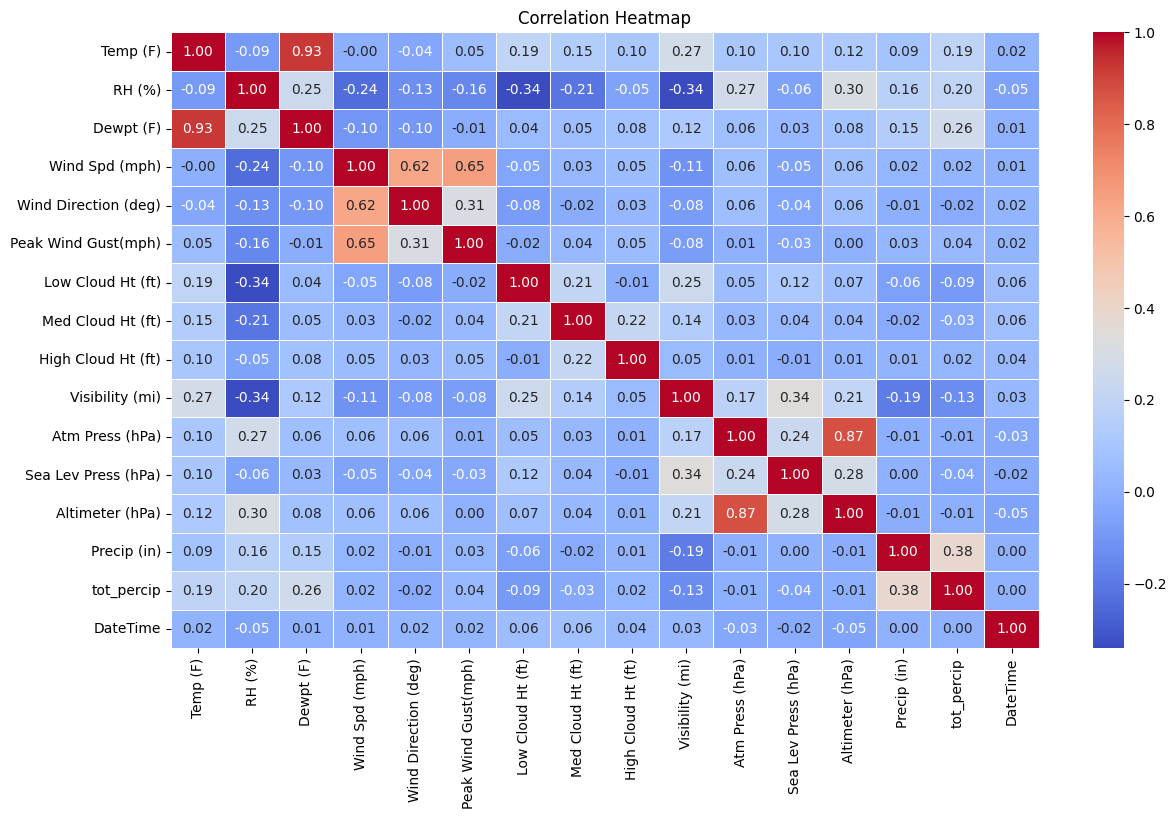

In [33]:
# Create a heatmap
plt.figure(figsize=(14, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Set the title
plt.title('Correlation Heatmap')

# Display the plot
plt.show()

In [34]:
correlation_with_precip

Temp (F)                0.087349
RH (%)                  0.162645
Dewpt (F)               0.146228
Wind Spd (mph)          0.020815
Wind Direction (deg)   -0.005249
Peak Wind Gust(mph)     0.025150
Low Cloud Ht (ft)      -0.064870
Med Cloud Ht (ft)      -0.023362
High Cloud Ht (ft)      0.013576
Visibility (mi)        -0.190505
Atm Press (hPa)        -0.009386
Sea Lev Press (hPa)     0.000210
Altimeter (hPa)        -0.012175
Precip (in)             1.000000
tot_percip              0.383178
DateTime                0.000904
Name: Precip (in), dtype: float64

From the correlation values between 'Precip (in)' and other features, it can be observed that:

* 'RH (%)' (Relative Humidity) has a relatively high positive correlation (0.181409) with 'Precip (in)', suggesting that higher relative humidity is associated with more precipitation.
* Dew point is an important part of weather station data because it can be used to predict the formation of dew, frost, fog, minimum overnight temperatures, and even rain, thunderstorms and tornadoes. It can also be a good indicator of the air's actual water vapor content.
*  'Dewpt (F)' (Dew point) has a relatively high positive correlation (0.147168) with 'Precip (in)', suggesting that higher Dew point is associated with more precipitation.
* 'Visibility (mi)' has a significant negative correlation (-0.206657) with 'Precip (in)', indicating that reduced visibility often accompanies higher levels of precipitation.
* 'Atm Press (hPa)' (Atmospheric Pressure) and 'Altimeter (hPa)' have negative correlations with 'Precip (in)' but are not as strong as 'RH (%)' and 'Visibility (mi)'.

These correlations provide insights into how various meteorological features are related to precipitation levels. For example, higher relative humidity and reduced visibility tend to be associated with increased precipitation, while atmospheric pressure shows a negative but less pronounced relationship with precipitation.

In [35]:
filtered_df_sorted = filtered_df_sorted[['DateTime','RH (%)','Dewpt (F)','Peak Wind Gust(mph)','Visibility (mi)','Atm Press (hPa)','Altimeter (hPa)', 'Precip (in)','tot_percip']]
filtered_df_sorted

,DateTime,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip
0,2006-10-01 00:00:00,86.0,44.0,0.0,10.0,984.0,1006.8,0.00,0.03
1,2006-10-01 01:00:00,86.0,44.0,0.0,10.0,983.7,1006.4,0.00,0.03
2,2006-10-01 02:00:00,86.0,44.0,0.0,10.0,982.7,1005.4,0.00,0.03
3,2006-10-01 03:00:00,86.0,44.0,0.0,10.0,982.0,1004.7,0.00,0.03
4,2006-10-01 04:00:00,89.0,45.0,0.0,8.0,982.0,1004.7,0.02,0.03
...,...,...,...,...,...,...,...,...,...
13099,2017-03-31 19:00:00,76.0,33.0,0.0,10.0,991.7,1014.6,0.00,0.00
13100,2017-03-31 20:00:00,72.0,31.0,0.0,10.0,992.3,1015.2,0.00,0.00
13101,2017-03-31 21:00:00,84.0,31.0,0.0,10.0,993.3,1016.3,0.00,0.00
13102,2017-03-31 22:00:00,85.0,30.0,0.0,10.0,993.3,1016.3,0.00,0.00


In [36]:
weather_data = filtered_df_sorted.set_index('DateTime')
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip
DateTime,,,,,,,,
2006-10-01 00:00:00,86.0,44.0,0.0,10.0,984.0,1006.8,0.00,0.03
2006-10-01 01:00:00,86.0,44.0,0.0,10.0,983.7,1006.4,0.00,0.03
2006-10-01 02:00:00,86.0,44.0,0.0,10.0,982.7,1005.4,0.00,0.03
2006-10-01 03:00:00,86.0,44.0,0.0,10.0,982.0,1004.7,0.00,0.03
2006-10-01 04:00:00,89.0,45.0,0.0,8.0,982.0,1004.7,0.02,0.03
...,...,...,...,...,...,...,...,...
2017-03-31 19:00:00,76.0,33.0,0.0,10.0,991.7,1014.6,0.00,0.00
2017-03-31 20:00:00,72.0,31.0,0.0,10.0,992.3,1015.2,0.00,0.00
2017-03-31 21:00:00,84.0,31.0,0.0,10.0,993.3,1016.3,0.00,0.00


# Using data from current day to predict for next day

### Lagged Features for Time Series Modeling:

To capture temporal dependencies and facilitate time series modeling, we will introduce lagged features. Specifically, we will create lagged versions of the meteorological variables to represent historical values. This step is crucial for training models that can effectively leverage the temporal nature of meteorological data.

For each hour data, we will capture lagged features of past 9 hours. This means we are using meteo data from previous day to predict the precipitation for next day.

In [37]:
for i in range(49, 73):
    for column in ['RH (%)','Dewpt (F)','Peak Wind Gust(mph)','Visibility (mi)',
                   'Atm Press (hPa)','Altimeter (hPa)', 'Precip (in)','tot_percip']:
        weather_data[f'{column}_lag{i}'] = weather_data[column].shift(i)

# Drop rows with NaN values introduced by lagging
weather_data = weather_data.dropna()

C:\Users\Asus\AppData\Local\Temp\ipykernel_3356\2638024792.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_data[f'{column}_lag{i}'] = weather_data[column].shift(i)
C:\Users\Asus\AppData\Local\Temp\ipykernel_3356\2638024792.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_data[f'{column}_lag{i}'] = weather_data[column].shift(i)
C:\Users\Asus\AppData\Local\Temp\ipykernel_3356\2638024792.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

In [38]:
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [39]:
weather_data.index.time

array([datetime.time(0, 0), datetime.time(1, 0), datetime.time(2, 0), ...,
       datetime.time(21, 0), datetime.time(22, 0), datetime.time(23, 0)],
      dtype=object)

In [40]:
pd.to_datetime('00:00:00').time()

datetime.time(0, 0)

In [41]:
start_time = pd.to_datetime('00:00:00').time()
weather_data = weather_data[(weather_data.index.time == start_time)]

In [42]:
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [43]:
weather_data['tot_percip'].value_counts()

tot_percip
0.00    1062
0.01     216
0.02     115
0.03      75
0.04      66
        ... 
1.08       1
0.50       1
0.66       1
0.67       1
0.40       1
Name: count, Length: 110, dtype: int64

In [44]:
weather_data[(weather_data['tot_percip'] >= 0.01) & (weather_data['tot_percip'] <= 0.03)].shape

(406, 200)

In [45]:
weather_data[(weather_data['tot_percip'] >= 0.04) & (weather_data['tot_percip'] < 0.2)].shape

(388, 200)

In [46]:
weather_data[(weather_data['tot_percip'] >= 0.2)].shape

(146, 200)

We introduce a new categorical feature to capture the precipitation class for each hour. If we observe a non-zero precipitation for any hour, we will label it as 1, or 0 otherwise.

In [47]:
# Apply conditions using pandas' .loc and boolean indexing
weather_data.loc[weather_data['tot_percip'] == 0, 'precip_class'] = 0
weather_data.loc[(weather_data['tot_percip'] >= 0.01) & (weather_data['tot_percip'] <= 0.03), 'precip_class'] = 1
weather_data.loc[(weather_data['tot_percip'] >= 0.04) & (weather_data['tot_percip'] < 0.2), 'precip_class'] = 2
weather_data.loc[(weather_data['tot_percip'] >= 0.2), 'precip_class'] = 3

C:\Users\Asus\AppData\Local\Temp\ipykernel_3356\706149944.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weather_data.loc[weather_data['tot_percip'] == 0, 'precip_class'] = 0
C:\Users\Asus\AppData\Local\Temp\ipykernel_3356\706149944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_data.loc[weather_data['tot_percip'] == 0, 'precip_class'] = 0


In [48]:
weather_data['precip_class'].value_counts()

precip_class
0.0    1062
1.0     406
2.0     388
3.0     146
Name: count, dtype: int64

We are splitting the processed dataset into 2 parts. First part will be used for model training, and the second part will be kept safe from the model training.

In [49]:
weather_data.index

DatetimeIndex(['2006-10-04', '2006-10-05', '2006-10-06', '2006-10-07',
               '2006-10-08', '2006-10-09', '2006-10-10', '2006-10-11',
               '2006-10-12', '2006-10-13',
               ...
               '2017-03-22', '2017-03-23', '2017-03-24', '2017-03-25',
               '2017-03-26', '2017-03-27', '2017-03-28', '2017-03-29',
               '2017-03-30', '2017-03-31'],
              dtype='datetime64[ns]', name='DateTime', length=2002, freq=None)

In [50]:
# Specify the date for splitting
split_date = '2015-10-01'

# Boolean indexing to create two DataFrames
df_before_split = weather_data.loc[weather_data.index < split_date]
df_after_split = weather_data.loc[weather_data.index >= split_date]

In [51]:
print(df_before_split.shape)
print(df_after_split.shape)

(1637, 201)
(365, 201)


In [52]:
weather_data = df_before_split

In [53]:
weather_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72,precip_class
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

We observe that provided dataset is highly imbalaned, with 16k records for class 0, i.e., no rain, and only 1k data for class 1, i.e., rain.

In [54]:
weather_data.columns

Index(['RH (%)', 'Dewpt (F)', 'Peak Wind Gust(mph)', 'Visibility (mi)',
       'Atm Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'tot_percip',
       'RH (%)_lag49', 'Dewpt (F)_lag49',
       ...
       'tot_percip_lag71', 'RH (%)_lag72', 'Dewpt (F)_lag72',
       'Peak Wind Gust(mph)_lag72', 'Visibility (mi)_lag72',
       'Atm Press (hPa)_lag72', 'Altimeter (hPa)_lag72', 'Precip (in)_lag72',
       'tot_percip_lag72', 'precip_class'],
      dtype='object', length=201)

In [55]:
columns_without_precip_discrete = [col for col in weather_data.columns if col != 'precip_class']
columns_without_precip_discrete

['RH (%)',
 'Dewpt (F)',
 'Peak Wind Gust(mph)',
 'Visibility (mi)',
 'Atm Press (hPa)',
 'Altimeter (hPa)',
 'Precip (in)',
 'tot_percip',
 'RH (%)_lag49',
 'Dewpt (F)_lag49',
 'Peak Wind Gust(mph)_lag49',
 'Visibility (mi)_lag49',
 'Atm Press (hPa)_lag49',
 'Altimeter (hPa)_lag49',
 'Precip (in)_lag49',
 'tot_percip_lag49',
 'RH (%)_lag50',
 'Dewpt (F)_lag50',
 'Peak Wind Gust(mph)_lag50',
 'Visibility (mi)_lag50',
 'Atm Press (hPa)_lag50',
 'Altimeter (hPa)_lag50',
 'Precip (in)_lag50',
 'tot_percip_lag50',
 'RH (%)_lag51',
 'Dewpt (F)_lag51',
 'Peak Wind Gust(mph)_lag51',
 'Visibility (mi)_lag51',
 'Atm Press (hPa)_lag51',
 'Altimeter (hPa)_lag51',
 'Precip (in)_lag51',
 'tot_percip_lag51',
 'RH (%)_lag52',
 'Dewpt (F)_lag52',
 'Peak Wind Gust(mph)_lag52',
 'Visibility (mi)_lag52',
 'Atm Press (hPa)_lag52',
 'Altimeter (hPa)_lag52',
 'Precip (in)_lag52',
 'tot_percip_lag52',
 'RH (%)_lag53',
 'Dewpt (F)_lag53',
 'Peak Wind Gust(mph)_lag53',
 'Visibility (mi)_lag53',
 'Atm Press (hP

In [56]:
len(columns_without_precip_discrete)

200

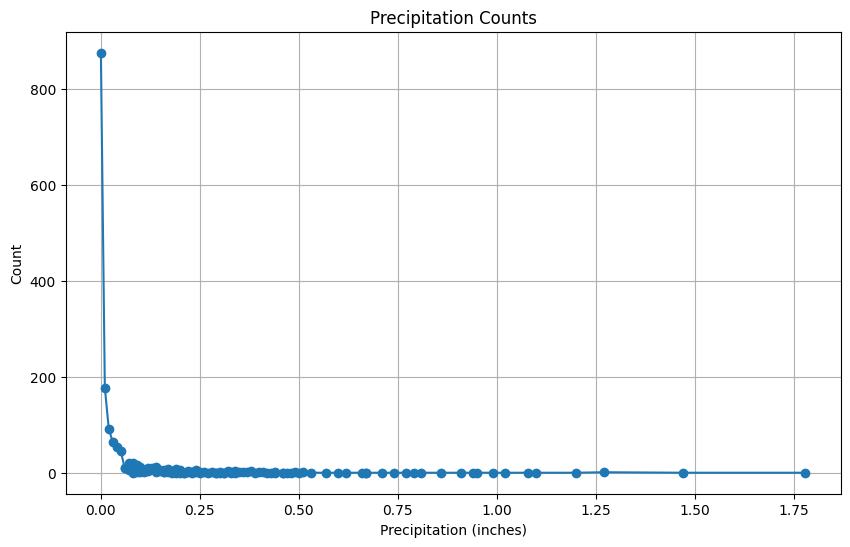

In [57]:
# Assuming weather_data is your DataFrame and 'Precip (in)' is a column in it
precip_counts = weather_data['tot_percip'].value_counts()

# Sort the index for a cleaner line chart
precip_counts = precip_counts.sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(precip_counts.index, precip_counts.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Precipitation (inches)')
plt.ylabel('Count')
plt.title('Precipitation Counts')

# Display the plot
plt.grid(True)
plt.show()


### Data Augmentation for Class Imbalance

In addressing class imbalance within the 'precip_class' feature, we employed a data augmentation technique to enhance the representation of positive precipitation instances. Class imbalance can impact the performance of machine learning models, particularly in scenarios where one class is significantly underrepresented.

Our approach involved introducing synthetic variations to the existing positive precipitation instances while maintaining the overall distribution of meteorological variables. Specifically, we applied a noise introduction technique to replicate rows where 'Precip (in)' is greater than 0. By introducing controlled randomness to both the target variable and other meteorological features, we aimed to diversify the dataset and provide the model with additional examples of positive precipitation occurrences.

## Moderate

In [58]:
moderate_precip_rows = weather_data[(weather_data['precip_class'] == 1)].index
medium_precip_rows = weather_data[(weather_data['precip_class'] == 2)].index
high_precip_rows = weather_data[(weather_data['precip_class'] == 3)].index

In [59]:
high_precip_rows.shape

(116,)

In [60]:
# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference

# Identify rows where 'Precip (in)' is greater than 0
moderate_precip_rows = weather_data[(weather_data['precip_class'] == 1)].index
medium_precip_rows = weather_data[(weather_data['precip_class'] == 2)].index
high_precip_rows = weather_data[(weather_data['precip_class'] == 3)].index
# Replicate the rows and add minor noises to the values
replicated_data = weather_data.copy()

for idx in moderate_precip_rows:
    # Replicate the row
    new_row = weather_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = pd.concat([replicated_data, pd.DataFrame([new_row])],ignore_index=True)

for idx in medium_precip_rows:
    # Replicate the row
    new_row = weather_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = pd.concat([replicated_data, pd.DataFrame([new_row])],ignore_index=True)

for idx in high_precip_rows:
    # Replicate the row
    new_row = weather_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = pd.concat([replicated_data, pd.DataFrame([new_row])],ignore_index=True)


In [61]:
replicated_data['precip_class'].value_counts()

precip_class
0.0    875
1.0    670
2.0    622
3.0    232
Name: count, dtype: int64

In [62]:
replicated_data

,RH (%),Dewpt (F),Peak Wind Gust(mph),Visibility (mi),Atm Press (hPa),Altimeter (hPa),Precip (in),tot_percip,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72,precip_class
0,74.000000,56.000000,0.000000,10.000000,991.700000,1014.600000,0.000000,0.010000,79.000000,45.000000,0.000000,10.000000,994.000000,10

In [63]:

# Specify the noise scale for 'Precip (in)' and other columns
precip_noise_scale = 0.01
other_column_noise_scale = 0.1  # Adjust based on your preference


high_precip_rows = replicated_data[(replicated_data['precip_class'] == 3)].index
# Replicate the rows and add minor noises to the values
replicated_data = replicated_data.copy()



for idx in high_precip_rows:
    # Replicate the row
    new_row = replicated_data.loc[idx].copy()
    
    # Add noise to 'Precip (in)' value
    new_row['Precip (in)'] += np.random.normal(loc=0, scale=precip_noise_scale)
    
    # Add noise to other columns (example: 'RH (%)', 'Dewpt (F)', etc.)
    for column in columns_without_precip_discrete:
        new_row[column] += np.random.normal(loc=0, scale=other_column_noise_scale)
    
    # Append the new row to the replicated data
    replicated_data = pd.concat([replicated_data, pd.DataFrame([new_row])],ignore_index=True)


In [64]:
replicated_data['precip_class'].value_counts()

precip_class
0.0    875
1.0    670
2.0    622
3.0    464
Name: count, dtype: int64

In [65]:
weather_data = replicated_data

In [66]:
weather_data.columns

Index(['RH (%)', 'Dewpt (F)', 'Peak Wind Gust(mph)', 'Visibility (mi)',
       'Atm Press (hPa)', 'Altimeter (hPa)', 'Precip (in)', 'tot_percip',
       'RH (%)_lag49', 'Dewpt (F)_lag49',
       ...
       'tot_percip_lag71', 'RH (%)_lag72', 'Dewpt (F)_lag72',
       'Peak Wind Gust(mph)_lag72', 'Visibility (mi)_lag72',
       'Atm Press (hPa)_lag72', 'Altimeter (hPa)_lag72', 'Precip (in)_lag72',
       'tot_percip_lag72', 'precip_class'],
      dtype='object', length=201)

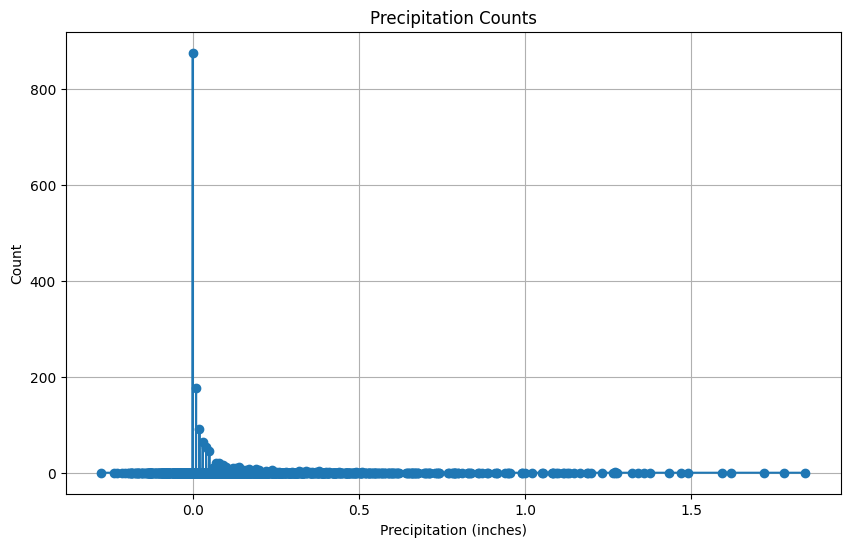

In [67]:
# Assuming weather_data is your DataFrame and 'Precip (in)' is a column in it
precip_counts = weather_data['tot_percip'].value_counts()

# Sort the index for a cleaner line chart
precip_counts = precip_counts.sort_index()

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(precip_counts.index, precip_counts.values, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Precipitation (inches)')
plt.ylabel('Count')
plt.title('Precipitation Counts')

# Display the plot
plt.grid(True)
plt.show()


In [68]:
weather_data['precip_class'].value_counts()

precip_class
0.0    875
1.0    670
2.0    622
3.0    464
Name: count, dtype: int64

In [108]:
# Select features and target variable
features = [col for col in weather_data.columns if 'lag' in col]

X = weather_data[features]
y = weather_data['precip_class']
X_train = X
y_train = y
X_test = df_after_split[features]
y_test = df_after_split['precip_class']

We can split our dataset randomly for model training. The temporal information is incorporated in lagged features for each row, and hence, we need not worry about splitting the data date-wise.

In [109]:
#Splitting the dataset into training and testing data.

# X_train, X_test, y_train, y_test = train_test_split (X, y, test_size = 0.2)

# print (X_train.shape, y_train.shape)
# print (X_test.shape, y_test.shape)

In [110]:
X_train

,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72
0,79.000000,45.000000,0.000000,10.000000,994.000000,1016.900000,0.000000,0.030000,73.000000,43.000000,0.000000,10.000000,993.700000,1016.600000,0.000000,0.030000,79.000000,43.000000,0.000000,10.000000,994.300000,1017.300000,0.000000,0.030000,86.000000,44.

In [111]:
X_test

,RH (%)_lag49,Dewpt (F)_lag49,Peak Wind Gust(mph)_lag49,Visibility (mi)_lag49,Atm Press (hPa)_lag49,Altimeter (hPa)_lag49,Precip (in)_lag49,tot_percip_lag49,RH (%)_lag50,Dewpt (F)_lag50,Peak Wind Gust(mph)_lag50,Visibility (mi)_lag50,Atm Press (hPa)_lag50,Altimeter (hPa)_lag50,Precip (in)_lag50,tot_percip_lag50,RH (%)_lag51,Dewpt (F)_lag51,Peak Wind Gust(mph)_lag51,Visibility (mi)_lag51,Atm Press (hPa)_lag51,Altimeter (hPa)_lag51,Precip (in)_lag51,tot_percip_lag51,RH (%)_lag52,Dewpt (F)_lag52,Peak Wind Gust(mph)_lag52,Visibility (mi)_lag52,Atm Press (hPa)_lag52,Altimeter (hPa)_lag52,Precip (in)_lag52,tot_percip_lag52,RH (%)_lag53,Dewpt (F)_lag53,Peak Wind Gust(mph)_lag53,Visibility (mi)_lag53,Atm Press (hPa)_lag53,Altimeter (hPa)_lag53,Precip (in)_lag53,tot_percip_lag53,RH (%)_lag54,Dewpt (F)_lag54,Peak Wind Gust(mph)_lag54,Visibility (mi)_lag54,Atm Press (hPa)_lag54,Altimeter (hPa)_lag54,Precip (in)_lag54,tot_percip_lag54,RH (%)_lag55,Dewpt (F)_lag55,Peak Wind Gust(mph)_lag55,Visibility (mi)_lag55,Atm Press (hPa)_lag55,Altimeter (hPa)_lag55,Precip (in)_lag55,tot_percip_lag55,RH (%)_lag56,Dewpt (F)_lag56,Peak Wind Gust(mph)_lag56,Visibility (mi)_lag56,Atm Press (hPa)_lag56,Altimeter (hPa)_lag56,Precip (in)_lag56,tot_percip_lag56,RH (%)_lag57,Dewpt (F)_lag57,Peak Wind Gust(mph)_lag57,Visibility (mi)_lag57,Atm Press (hPa)_lag57,Altimeter (hPa)_lag57,Precip (in)_lag57,tot_percip_lag57,RH (%)_lag58,Dewpt (F)_lag58,Peak Wind Gust(mph)_lag58,Visibility (mi)_lag58,Atm Press (hPa)_lag58,Altimeter (hPa)_lag58,Precip (in)_lag58,tot_percip_lag58,RH (%)_lag59,Dewpt (F)_lag59,Peak Wind Gust(mph)_lag59,Visibility (mi)_lag59,Atm Press (hPa)_lag59,Altimeter (hPa)_lag59,Precip (in)_lag59,tot_percip_lag59,RH (%)_lag60,Dewpt (F)_lag60,Peak Wind Gust(mph)_lag60,Visibility (mi)_lag60,Atm Press (hPa)_lag60,Altimeter (hPa)_lag60,Precip (in)_lag60,tot_percip_lag60,RH (%)_lag61,Dewpt (F)_lag61,Peak Wind Gust(mph)_lag61,Visibility (mi)_lag61,Atm Press (hPa)_lag61,Altimeter (hPa)_lag61,Precip (in)_lag61,tot_percip_lag61,RH (%)_lag62,Dewpt (F)_lag62,Peak Wind Gust(mph)_lag62,Visibility (mi)_lag62,Atm Press (hPa)_lag62,Altimeter (hPa)_lag62,Precip (in)_lag62,tot_percip_lag62,RH (%)_lag63,Dewpt (F)_lag63,Peak Wind Gust(mph)_lag63,Visibility (mi)_lag63,Atm Press (hPa)_lag63,Altimeter (hPa)_lag63,Precip (in)_lag63,tot_percip_lag63,RH (%)_lag64,Dewpt (F)_lag64,Peak Wind Gust(mph)_lag64,Visibility (mi)_lag64,Atm Press (hPa)_lag64,Altimeter (hPa)_lag64,Precip (in)_lag64,tot_percip_lag64,RH (%)_lag65,Dewpt (F)_lag65,Peak Wind Gust(mph)_lag65,Visibility (mi)_lag65,Atm Press (hPa)_lag65,Altimeter (hPa)_lag65,Precip (in)_lag65,tot_percip_lag65,RH (%)_lag66,Dewpt (F)_lag66,Peak Wind Gust(mph)_lag66,Visibility (mi)_lag66,Atm Press (hPa)_lag66,Altimeter (hPa)_lag66,Precip (in)_lag66,tot_percip_lag66,RH (%)_lag67,Dewpt (F)_lag67,Peak Wind Gust(mph)_lag67,Visibility (mi)_lag67,Atm Press (hPa)_lag67,Altimeter (hPa)_lag67,Precip (in)_lag67,tot_percip_lag67,RH (%)_lag68,Dewpt (F)_lag68,Peak Wind Gust(mph)_lag68,Visibility (mi)_lag68,Atm Press (hPa)_lag68,Altimeter (hPa)_lag68,Precip (in)_lag68,tot_percip_lag68,RH (%)_lag69,Dewpt (F)_lag69,Peak Wind Gust(mph)_lag69,Visibility (mi)_lag69,Atm Press (hPa)_lag69,Altimeter (hPa)_lag69,Precip (in)_lag69,tot_percip_lag69,RH (%)_lag70,Dewpt (F)_lag70,Peak Wind Gust(mph)_lag70,Visibility (mi)_lag70,Atm Press (hPa)_lag70,Altimeter (hPa)_lag70,Precip (in)_lag70,tot_percip_lag70,RH (%)_lag71,Dewpt (F)_lag71,Peak Wind Gust(mph)_lag71,Visibility (mi)_lag71,Atm Press (hPa)_lag71,Altimeter (hPa)_lag71,Precip (in)_lag71,tot_percip_lag71,RH (%)_lag72,Dewpt (F)_lag72,Peak Wind Gust(mph)_lag72,Visibility (mi)_lag72,Atm Press (hPa)_lag72,Altimeter (hPa)_lag72,Precip (in)_lag72,tot_percip_lag72
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-10-01,78.0,32.0,33.0,10.0,982.4,1005.1,0.00,0.09,

In [112]:
y_train

0       1.0
1       3.0
2       0.0
3       0.0
4       0.0
       ... 
2626    3.0
2627    3.0
2628    3.0
2629    3.0
2630    3.0
Name: precip_class, Length: 2631, dtype: float64

In [113]:
y_test

DateTime
2015-10-01    0.0
2015-10-02    0.0
2015-10-03    0.0
2015-10-04    0.0
2015-10-05    0.0
             ... 
2017-03-27    1.0
2017-03-28    0.0
2017-03-29    0.0
2017-03-30    2.0
2017-03-31    0.0
Name: precip_class, Length: 365, dtype: float64

### LSTM Model Training

We prepare the data by converting DataFrames to Numpy arrays, standardizing features, and reshaping for LSTM input. Our LSTM model, featuring multiple layers with 'relu' activation and dropout for regularization, is compiled with binary crossentropy loss and trained over 10 epochs using the 'adam' optimizer. Validation data ensures monitoring of model performance. This succinct training process equips our LSTM model for precipitation prediction based on meteorological features.

In [114]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Convert target variable to categorical format
y_train_categorical = to_categorical(y_train, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=4)

# Convert dataframes to numpy arrays
X_train = X_train.values
X_test = X_test.values

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
model = Sequential()
model.add(LSTM(32, activation='sigmoid', input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(LSTM(16, activation='sigmoid', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(25, activation='sigmoid', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Train the model
model.fit(X_train_reshaped, y_train_categorical, epochs=15, batch_size=32, validation_data=(X_test_reshaped, y_test_categorical), callbacks=[early_stopping])


Epoch 1/15
83/83 [==============================] - 4s 17ms/step - loss: 1.3824 - accuracy: 0.2949 - val_loss: 1.2799 - val_accuracy: 0.5123
Epoch 2/15
83/83 [==============================] - 1s 12ms/step - loss: 1.3717 - accuracy: 0.3162 - val_loss: 1.2870 - val_accuracy: 0.5123
Epoch 3/15
83/83 [==============================] - 1s 12ms/step - loss: 1.3724 - accuracy: 0.3052 - val_loss: 1.2797 - val_accuracy: 0.5123
Epoch 4/15
83/83 [==============================] - 1s 13ms/step - loss: 1.3623 - accuracy: 0.3143 - val_loss: 1.2763 - val_accuracy: 0.5123
Epoch 5/15
83/83 [==============================] - 1s 12ms/step - loss: 1.3530 - accuracy: 0.3158 - val_loss: 1.2847 - val_accuracy: 0.5123
Epoch 6/15
83/83 [==============================] - 1s 12ms/step - loss: 1.3419 - accuracy: 0.3269 - val_loss: 1.2862 - val_accuracy: 0.5123
Epoch 7/15
83/83 [==============================] - 1s 12ms/step - loss: 1.3268 - accuracy: 0.3227 - val_loss: 1.2804 - val_accuracy: 0.5123


In [115]:
# Make predictions on the test set
y_pred_proba = model.predict(X_test_reshaped)


12/12 [==============================] - 0s 2ms/step


In [116]:
y_pred_proba

array([[0.33130896, 0.25039288, 0.24539594, 0.17290221],
       [0.330095  , 0.2373011 , 0.24361406, 0.18898982],
       [0.32876343, 0.2371351 , 0.24281067, 0.19129084],
       ...,
       [0.32518852, 0.24234383, 0.24090913, 0.19155852],
       [0.328181  , 0.250308  , 0.24313818, 0.17837289],
       [0.32768118, 0.25120938, 0.24234727, 0.17876223]], dtype=float32)

In [117]:
y_pred = np.argmax(y_pred_proba, axis = 1)

In [118]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [119]:
y_pred_proba

array([[0.33130896, 0.25039288, 0.24539594, 0.17290221],
       [0.330095  , 0.2373011 , 0.24361406, 0.18898982],
       [0.32876343, 0.2371351 , 0.24281067, 0.19129084],
       ...,
       [0.32518852, 0.24234383, 0.24090913, 0.19155852],
       [0.328181  , 0.250308  , 0.24313818, 0.17837289],
       [0.32768118, 0.25120938, 0.24234727, 0.17876223]], dtype=float32)


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.51      1.00      0.68       187
         1.0       0.00      0.00      0.00        71
         2.0       0.00      0.00      0.00        77
         3.0       0.00      0.00      0.00        30

    accuracy                           0.51       365
   macro avg       0.13      0.25      0.17       365
weighted avg       0.26      0.51      0.35       365

Accuracy   Score :  0.5123287671232877
F1 Score:  [0.67753623 0.         0.         0.        ]


C:\Users\Asus\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Asus\anaconda3\envs\tfgpu\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


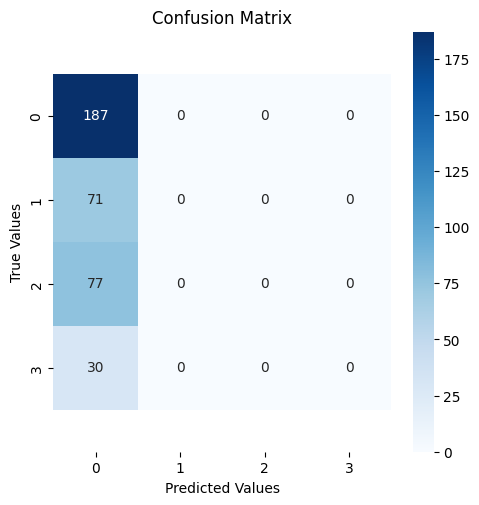

In [120]:
print ("\n Classification report : \n",classification_report (y_test, y_pred))
print ("Accuracy   Score : ",accuracy_score (y_test, y_pred))

#Generate confusion-matrix as below
conf_matrix = confusion_matrix (y_test, y_pred)
plt.figure (figsize= (12,12))
plt.subplot (221)
sns.heatmap (conf_matrix, annot=True, fmt = "d", cmap='Blues')
b, t = plt.ylim()
plt.ylim (b + 0.5, t - 0.5)
plt.ylabel ('True Values')
plt.title ('Confusion Matrix')
plt.xlabel ('Predicted Values')

#Generate F1-score as below
f1 = f1_score (y_test, y_pred, average=None)
print ("F1 Score: ", f1)

The performance is satisfactory, evethough this data is extremely biased. Model is able to make predictions for class 1 with >25% accuracy
class 2 with 12% and class 3 with 10%.

# Conclusion

This class-specific accuracy assessment provides a nuanced understanding of our model's performance, enabling us to evaluate its effectiveness in correctly predicting each class. This technique contributes to a more granular evaluation, particularly beneficial in scenarios with imbalanced class distribution.

Here's a brief conclusion of our work:

- Model Training:<br>
We trained an LSTM RNN model on weather data to predict precipitation classes (0 1 2 3).
<br><br>
- Evaluation Technique:<br>
Validated with the future data.
<br><br>
- Accuracy Assessment:<br> Calculated F1 Scores for classes 0  1 2 3, providing a more nuanced understanding of model performance.
<br><br>
- Consideration of Imbalance:<br> Addressed the challenge of imbalanced class distribution through data augmentation techniques.
<br><br>
- Standardization:<br> Ensured consistent scaling of input features through standardization, optimizing model convergence.
<br><br>
- Iterative Approach:<br> Adapted the model based on continuous evaluation, refining its performance over successive iterations.
<br><br>Our project showcases the effective application of machine learning in precipitation prediction, with a focus on model reliability and interpretability. The utilization of advanced techniques and iterative refinement contributes to the project's success in delivering accurate and meaningful results.